Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("D:\CNN_assignment_data\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test = pathlib.Path('D:\CNN_assignment_data\Skin cancer ISIC The International Skin Imaging Collaboration\Test')

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [5]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split = 0.15,
    subset = 'training',
    image_size = (img_height, img_width),
    batch_size=batch_size

)

Found 2239 files belonging to 9 classes.
Using 1904 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.15,
    subset="validation",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size

)

Found 2239 files belonging to 9 classes.
Using 335 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

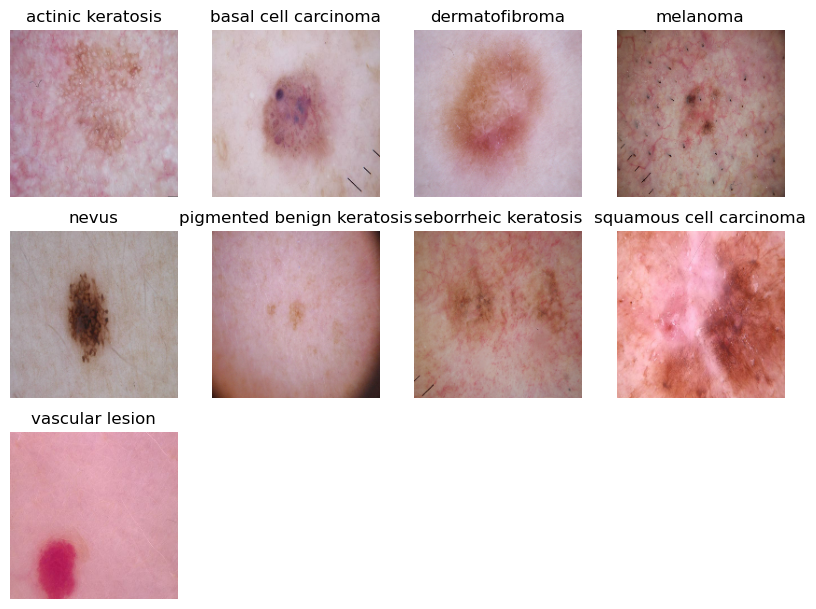

In [74]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10,10))
for i in range(len(class_names)):
  filtered_ds = train_ds.filter(lambda x,l:tf.math.equal(l[0], i))
  for image, label in filtered_ds.take(1):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(image[0].numpy().astype('uint8'))
    plt.title(class_names[label.numpy()[0]])
    plt.axis('off')


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


60/60 [==============================] - 25s 224ms/step - loss: 2.0749 - accuracy: 0.2658 - val_loss: 1.8044 - val_accuracy: 0.3851
Epoch 2/20
60/60 [==============================] - 12s 193ms/step - loss: 1.7167 - accuracy: 0.3939 - val_loss: 1.5255 - val_accuracy: 0.4955
Epoch 3/20
60/60 [==============================] - 11s 192ms/step - loss: 1.4616 - accuracy: 0.4811 - val_loss: 1.5122 - val_accuracy: 0.4896
Epoch 4/20
60/60 [==============================] - 11s 192ms/step - loss: 1.3319 - accuracy: 0.5247 - val_loss: 1.4350 - val_accuracy: 0.5164
Epoch 5/20
60/60 [==============================] - 12s 194ms/step - loss: 1.2947 - accuracy: 0.5373 - val_loss: 1.4612 - val_accuracy: 0.5104
Epoch 6/20
60/60 [==============================] - 12s 193ms/step - loss: 1.1975 - accuracy: 0.5856 - val_loss: 1.4900 - val_accuracy: 0.5194
Epoch 7/20
60/60 [==============================] - 12s 192ms/step - loss: 1.1017 - accuracy: 0.6140 - val_loss: 1.4125 - val_accuracy: 0.53

### Visualizing training results

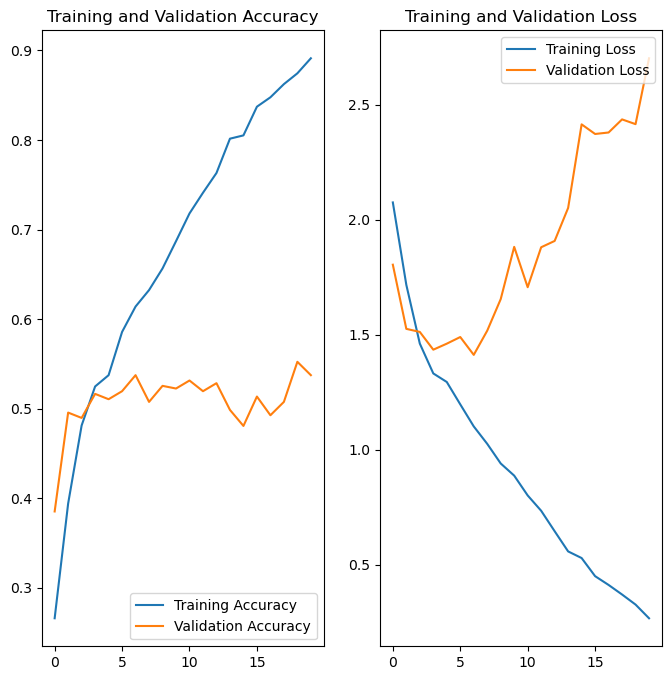

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

###Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

Findings:
1. Observations indicate a significant disparity between Training and Validation Accuracies, suggesting overfitting in the model.
2. The Validation Accuracy of the model is noted to be under 55%.
3. To address the overfitting problem, it is recommended to implement methods such as Data Augmentation and Dropout.

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

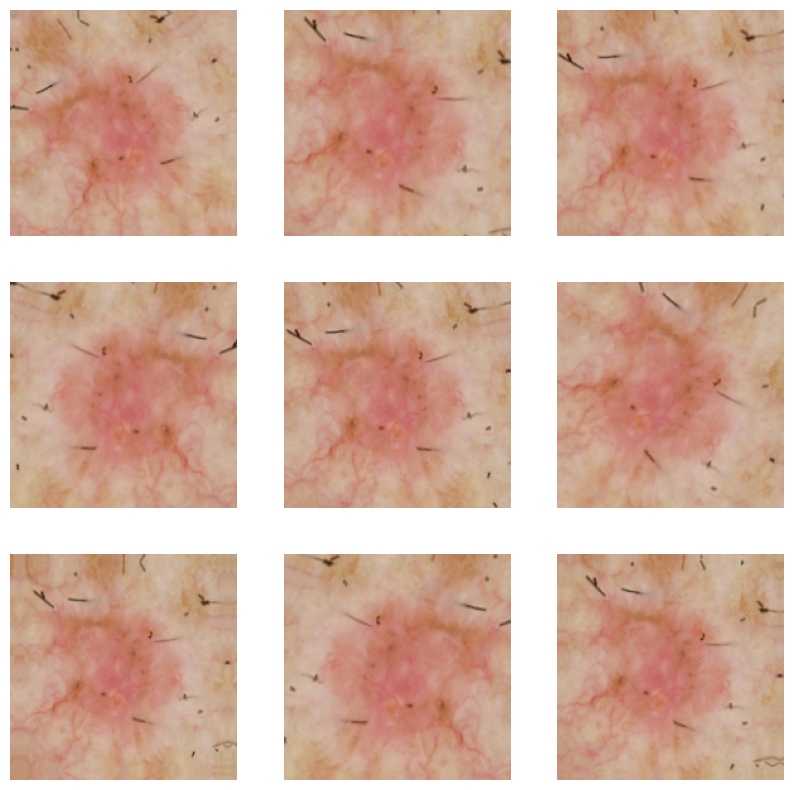

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [22]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
60/60 [==============================] - 20s 286ms/step - loss: 2.1813 - accuracy: 0.2132 - val_loss: 1.8864 - val_accuracy: 0.3672
Epoch 2/20
60/60 [==============================] - 17s 285ms/step - loss: 1.8771 - accuracy: 0.3036 - val_loss: 1.7642 - val_accuracy: 0.3552
Epoch 3/20
60/60 [==============================] - 17s 287ms/step - loss: 1.7060 - accuracy: 0.4013 - val_loss: 1.6422 - val_accuracy: 0.4478
Epoch 4/20
60/60 [==============================] - 11s 189ms/step - loss: 1.5091 - accuracy: 0.4496 - val_loss: 1.4577 - val_accuracy: 0.4836
Epoch 5/20
60/60 [==============================] - 10s 174ms/step - loss: 1.4232 - accuracy: 0.4958 - val_loss: 1.4268 - val_accuracy: 0.5075
Epoch 6/20
60/60 [==============================] - 10s 170ms/step - loss: 1.3684 - accuracy: 0.5179 - val_loss: 1.6705 - val_accuracy: 0.4119
Epoch 7/20
60/60 [==============================] - 10s 171ms/step - loss: 1.3306 - accuracy: 0.5268 - val_loss: 1.6484 - val_accuracy: 0.4567

### Visualizing the results

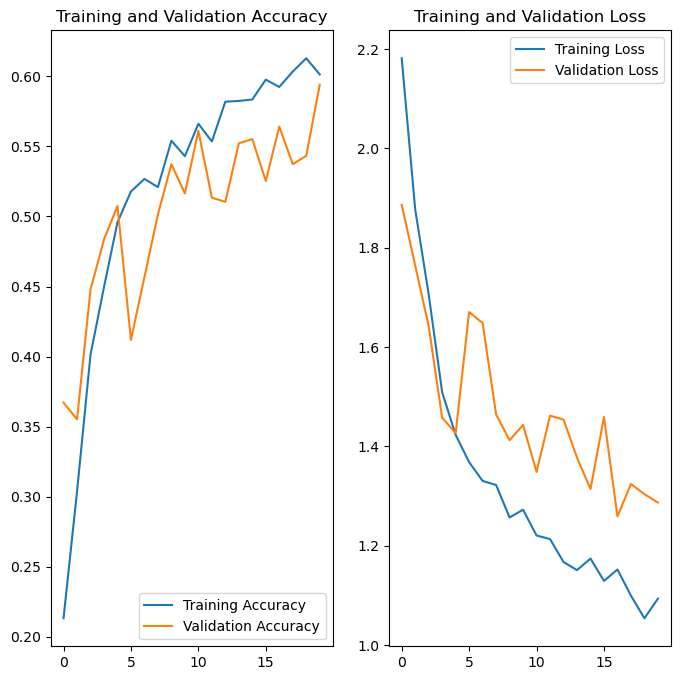

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Training and Validation accuracies are closely aligned, both reaching a peak near 60%.
This similarity in accuracy levels highlights the effectiveness of Data Augmentation in enhancing model performance.
There is potential for further improvement in the model's accuracy.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [30]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict_original = dict(zip(path_list, lesion_list))
df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
df



,Path,Label
0,D:\CNN_assignment_data\Skin cancer ISIC The In...,actinic keratosis
1,D:\CNN_assignment_data\Skin cancer ISIC The In...,actinic keratosis
2,D:\CNN_assignment_data\Skin cancer ISIC The In...,actinic keratosis
3,D:\CNN_assignment_data\Skin cancer ISIC The In...,actinic keratosis
4,D:\CNN_assignment_data\Skin cancer ISIC The In...,actinic keratosis
...,...,...
2234,D:\CNN_assignment_data\Skin cancer ISIC The In...,vascular lesion
2235,D:\CNN_assignment_data\Skin cancer ISIC The In...,vascular lesion
2236,D:\CNN_assignment_data\Skin cancer ISIC The In...,vascular lesion
2237,D:\CNN_assignment_data\Skin cancer ISIC The In...,vascular lesion


Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


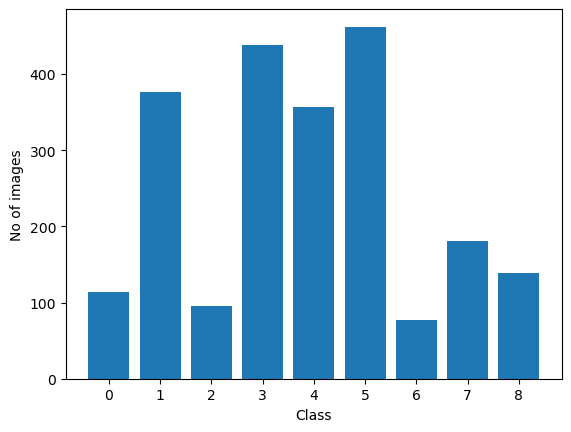

In [31]:
## Your code goes here.

from sklearn.preprocessing import LabelEncoder
from collections import Counter

X, y = df['Path'], df['Label']
y = LabelEncoder().fit_transform(y)
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.xticks([i for i in range(9)])
plt.xlabel("Class")
plt.ylabel("No of images")
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
From the above bar chart we can see that the class with label 6 has the least number of samples

#### - Which classes dominate the data in terms proportionate number of samples?
We can observe that of all the class, class with label 5 has the most number of samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [32]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [54]:
path_to_training_dataset="D:\CNN_assignment_data\Skin cancer ISIC The International Skin Imaging Collaboration\Train"
import Augmentor
for i in class_names:
    #print(Augmentor.Pipeline(path_to_training_dataset + "/" + i + '/output/'))
    p = Augmentor.Pipeline(str(path_to_training_dataset) + "/" + i, output_directory = path_to_training_dataset +'/'+ i +'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to D:\CNN_assignment_data\Skin cancer ISIC The International Skin Imaging Collaboration\Train/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D8AFDAE4D0>: 100%|█| 500/500 [00:02<00:00, 169.49 Samples


Initialised with 376 image(s) found.
Output directory set to D:\CNN_assignment_data\Skin cancer ISIC The International Skin Imaging Collaboration\Train/basal cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D8B4FBD910>: 100%|█| 500/500 [00:02<00:00, 168.87 Samples


Initialised with 95 image(s) found.
Output directory set to D:\CNN_assignment_data\Skin cancer ISIC The International Skin Imaging Collaboration\Train/dermatofibroma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1D8B50BCDD0>: 100%|█| 500/500 [00:03<00:


Initialised with 438 image(s) found.
Output directory set to D:\CNN_assignment_data\Skin cancer ISIC The International Skin Imaging Collaboration\Train/melanoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1D8B5A0A1D0>: 100%|█| 500/500 [00:17<00


Initialised with 357 image(s) found.
Output directory set to D:\CNN_assignment_data\Skin cancer ISIC The International Skin Imaging Collaboration\Train/nevus/output/.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x1D8B5131AD0>: 100%|█| 500/500 [00:15<00:00, 31.71 Samples/


Initialised with 462 image(s) found.
Output directory set to D:\CNN_assignment_data\Skin cancer ISIC The International Skin Imaging Collaboration\Train/pigmented benign keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1D8B5062510>: 100%|█| 500/500 [00:03<00:


Initialised with 77 image(s) found.
Output directory set to D:\CNN_assignment_data\Skin cancer ISIC The International Skin Imaging Collaboration\Train/seborrheic keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1D8B5A0A190>: 100%|█| 500/500 [00:08<00


Initialised with 181 image(s) found.
Output directory set to D:\CNN_assignment_data\Skin cancer ISIC The International Skin Imaging Collaboration\Train/squamous cell carcinoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1D8B50B2710>: 100%|█| 500/500 [00:03<00:


Initialised with 139 image(s) found.
Output directory set to D:\CNN_assignment_data\Skin cancer ISIC The International Skin Imaging Collaboration\Train/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D8B50D13D0>: 100%|█| 500/500 [00:03<00:00, 138.52 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [55]:
image_count_train = len(list(data_dir_train.glob('*\output\*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [57]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['D:\\CNN_assignment_data\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_f6f2ac53-bdf5-4165-b91f-3131d23e2eda.jpg',
 'D:\\CNN_assignment_data\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_bb874b86-76bc-42bd-ad29-2ffaa52a2a3c.jpg',
 'D:\\CNN_assignment_data\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_e7cadf61-af7e-41a6-a6a2-0471b7b2d30d.jpg',
 'D:\\CNN_assignment_data\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_c35c75c6-06e6-48d8-82e4-5d9ac8e85779.jpg',
 'D:\\CNN_assignment_data\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_

In [59]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [61]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [63]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df.append(df2)

C:\Users\alkar\AppData\Local\Temp\ipykernel_15008\2621963877.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = df.append(df2)


In [64]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [68]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [69]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to'',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [70]:
## your code goes here
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [71]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [72]:
epochs = 50
## Your code goes here, use 50 epochs.

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 34s 188ms/step - loss: 1.8346 - accuracy: 0.2967 - val_loss: 1.5682 - val_accuracy: 0.4016
Epoch 2/50
169/169 [==============================] - 32s 187ms/step - loss: 1.4888 - accuracy: 0.4295 - val_loss: 1.4639 - val_accuracy: 0.4684
Epoch 3/50
169/169 [==============================] - 32s 189ms/step - loss: 1.3836 - accuracy: 0.4649 - val_loss: 1.2986 - val_accuracy: 0.5145
Epoch 4/50
169/169 [==============================] - 34s 200ms/step - loss: 1.3099 - accuracy: 0.5002 - val_loss: 1.2280 - val_accuracy: 0.5397
Epoch 5/50
169/169 [==============================] - 35s 204ms/step - loss: 1.2811 - accuracy: 0.5057 - val_loss: 1.2513 - val_accuracy: 0.5278
Epoch 6/50
169/169 [==============================] - 35s 202ms/step - loss: 1.2160 - accuracy: 0.5321 - val_loss: 1.3284 - val_accuracy: 0.4826
Epoch 7/50
169/169 [==============================] - 35s 203ms/step - loss: 1.1839 - accuracy: 0.5462 - val_loss: 1.1827 - val_ac

#### **Todo:**  Visualize the model results

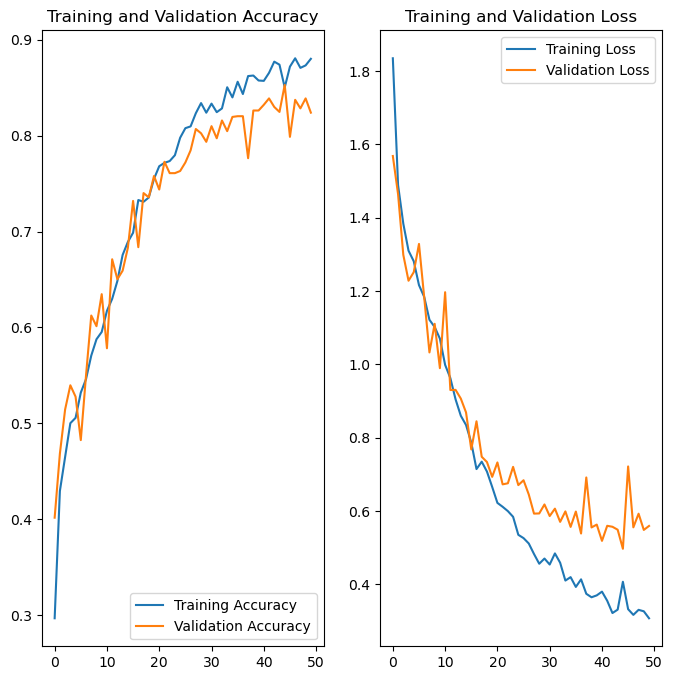

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



The model demonstrates satisfactory performance, achieving a maximum accuracy of approximately 88% 
for  the training and 82% for validation data. The implementation of strategies such as rectifying class imbalance and 
applying data augmentation has effectively enhanced the model's accuracy while mitigating overfitting issues.

Consequently, this model, developed using Convolutional Neural Networks (CNN), stands as a reliable tool for
predicting skin cancer.